In [1]:
"""
Modular Deep Successor Representation (SR) agent (Solution 1: factorized SR)
FULL CODE (single file)
- NO encoder MLP: uses expert dict observation directly -> fixed 5D vector
- topo module uses robot state: (x, y, theta)  (3 dims)
- social module uses closest human: (hx, hy)   (2 dims)
- learns SR TD targets per module
- control via SR readout weights (Q from <M,w>)
- exports per-episode episode_return and episode_length to CSV
- ALSO logs per-step reward and per-step episode-length-so-far
- returns:
    agent,
    episode_returns, episode_lengths,
    step_rewards, step_episode_len

Your call does NOT need to change (it will just receive 5 outputs instead of 3).
If you want to keep 3 outputs, unpack only the first 3 and ignore the rest.

Assumptions:
- env.reset(seed=...) -> (obs, info)
- env.step(a) -> (obs, reward, terminated, truncated, info)
- env.action_space.n is discrete
- obs is dict with keys: "robot" (len 3 or None), "humans" (len 2 or None)
"""

from __future__ import annotations
from dataclasses import dataclass
from typing import Any, Dict, Tuple, List, Union
import os
import csv
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


# ----------------------------
# Utils: observation flattening
# ----------------------------

def flatten_obs(obs: Any) -> np.ndarray:
    """
    Expects dict:
      obs["robot"]  -> [x, y, theta] or None
      obs["humans"] -> [hx, hy] or None (your wrapper often already returns zeros)
    Returns 1D float32: [rx, ry, rtheta, hx, hy] (shape (5,))
    """
    if not isinstance(obs, dict):
        raise TypeError(f"Expected dict obs, got {type(obs)}")

    robot = obs.get("robot", None)
    humans = obs.get("humans", None)

    if robot is None:
        r = np.zeros((3,), dtype=np.float32)
    else:
        r = np.asarray(robot, dtype=np.float32).reshape(-1)
        if r.size != 3:
            raise ValueError(f'obs["robot"] must have 3 values, got shape {r.shape}')
        if not np.isfinite(r[2]):  # theta None/nan/inf -> 0
            r[2] = 0.0
        r = np.nan_to_num(r, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32, copy=False)

    if humans is None:
        h = np.zeros((2,), dtype=np.float32)
    else:
        h = np.asarray(humans, dtype=np.float32).reshape(-1)
        if h.size != 2:
            raise ValueError(f'obs["humans"] must have 2 values, got shape {h.shape}')
        h = np.nan_to_num(h, nan=0.0, posinf=0.0, neginf=0.0).astype(np.float32, copy=False)

    out = np.concatenate([r, h], axis=0).astype(np.float32, copy=False)
    if out.shape[0] != 5:
        raise ValueError(f"flatten_obs must return 5 dims, got {out.shape}")
    return out


def to_tensor(x: np.ndarray, device: torch.device) -> torch.Tensor:
    return torch.as_tensor(x, dtype=torch.float32, device=device)


# ----------------------------
# Replay Buffer
# ----------------------------

@dataclass
class Transition:
    obs: np.ndarray
    action: Union[int, np.ndarray]
    reward: Union[float, np.ndarray]
    next_obs: np.ndarray
    done: Union[bool, np.ndarray]


class ReplayBuffer:
    def __init__(self, capacity: int):
        self.capacity = int(capacity)
        self.rng = random.Random()
        self.data: List[Transition] = []
        self.pos = 0

    def __len__(self) -> int:
        return len(self.data)

    def push(self, t: Transition) -> None:
        if len(self.data) < self.capacity:
            self.data.append(t)
        else:
            self.data[self.pos] = t
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size: int) -> Transition:
        batch = self.rng.sample(self.data, batch_size)
        obs = np.stack([b.obs for b in batch], axis=0)
        actions = np.asarray([b.action for b in batch], dtype=np.int64)
        rewards = np.asarray([b.reward for b in batch], dtype=np.float32)
        next_obs = np.stack([b.next_obs for b in batch], axis=0)
        dones = np.asarray([b.done for b in batch], dtype=np.float32)
        return Transition(obs=obs, action=actions, reward=rewards, next_obs=next_obs, done=dones)


# ----------------------------
# Networks (NO encoder)
# ----------------------------

class SRHead(nn.Module):
    """
    Action-conditioned SR head.
    Input: z_m (B, zdim)
    Output: M(z_m, a) for all actions -> (B, A, Dphi)
    """
    def __init__(
        self,
        z_dim: int,
        action_dim: int,
        phi_dim: int,
        hidden: Tuple[int, ...] = (256, 256),
    ):
        super().__init__()
        self.action_dim = int(action_dim)
        self.phi_dim = int(phi_dim)

        layers: List[nn.Module] = []
        last = int(z_dim)
        for h in hidden:
            layers += [nn.Linear(last, int(h)), nn.ReLU(inplace=True)]
            last = int(h)
        layers.append(nn.Linear(last, self.action_dim * self.phi_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        B = z.shape[0]
        out = self.net(z)  # (B, A*Dphi)
        return out.view(B, self.action_dim, self.phi_dim)


class ModularSRNet(nn.Module):
    """
    No encoder:
      obs_flat = [rx, ry, rtheta, hx, hy]  (len=5)
    Split:
      z_topo   = [rx, ry, rtheta] (3)
      z_social = [hx, hy]         (2)
    SR basis:
      phi_m(z_m) = normalize(P_m z_m.detach())
    """
    def __init__(
        self,
        obs_dim: int,
        action_dim: int,
        # kept for constructor compatibility (unused)
        z_dim: int = 256,
        z_topo_dim: int = 128,
        z_social_dim: int = 128,
        phi_topo_dim: int = 64,
        phi_social_dim: int = 64,
        enc_hidden: Tuple[int, ...] = (512, 256, 128, 64),  # unused
        sr_hidden: Tuple[int, ...] = (256, 256),
    ):
        super().__init__()
        if obs_dim != 5:
            raise ValueError(f"This no-encoder version expects obs_dim=5, got {obs_dim}")

        self.action_dim = int(action_dim)

        self.topo_dim = 3
        self.social_dim = 2

        self.phi_topo_dim = int(phi_topo_dim)
        self.phi_social_dim = int(phi_social_dim)

        self.phi_topo = nn.Linear(self.topo_dim, self.phi_topo_dim)
        self.phi_social = nn.Linear(self.social_dim, self.phi_social_dim)

        self.sr_topo = SRHead(self.topo_dim, self.action_dim, self.phi_topo_dim, hidden=sr_hidden)
        self.sr_social = SRHead(self.social_dim, self.action_dim, self.phi_social_dim, hidden=sr_hidden)

        self.w_topo = nn.Parameter(torch.zeros(self.phi_topo_dim))
        self.w_social = nn.Parameter(torch.zeros(self.phi_social_dim))

    def split(self, obs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        zt = obs[:, :3]   # (B,3)
        zs = obs[:, 3:5]  # (B,2)
        return zt, zs

    def phi(self, z_topo: torch.Tensor, z_social: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        pt = self.phi_topo(z_topo.detach())
        ps = self.phi_social(z_social.detach())
        pt = F.normalize(pt, dim=-1, eps=1e-6)
        ps = F.normalize(ps, dim=-1, eps=1e-6)
        return pt, ps

    def M_all(self, obs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        zt, zs = self.split(obs)
        Mt_all = self.sr_topo(zt)    # (B,A,Dt)
        Ms_all = self.sr_social(zs)  # (B,A,Ds)
        return zt, zs, Mt_all, Ms_all

    def Q_from_M(self, Mt_all: torch.Tensor, Ms_all: torch.Tensor) -> torch.Tensor:
        Qt = torch.einsum("bad,d->ba", Mt_all, self.w_topo)
        Qs = torch.einsum("bad,d->ba", Ms_all, self.w_social)
        return Qt + Qs


# ----------------------------
# Agent
# ----------------------------

class ModularSRAgent:
    def __init__(
        self,
        obs_dim: int,
        action_dim: int,
        device: Union[str, torch.device] = "cuda",
        gamma: float = 0.99,
        lr: float = 3e-3,
        target_tau: float = 0.005,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.05,
        epsilon_decay_steps: int = 60_000,
        z_dim: int = 256,
        z_topo_dim: int = 128,
        z_social_dim: int = 128,
        phi_topo_dim: int = 64,
        phi_social_dim: int = 64,
    ):
        self.device = torch.device(device)
        self.gamma = float(gamma)
        self.tau = float(target_tau)
        self.action_dim = int(action_dim)

        self.net = ModularSRNet(
            obs_dim=obs_dim,
            action_dim=action_dim,
            z_dim=z_dim,                 # unused
            z_topo_dim=z_topo_dim,       # unused
            z_social_dim=z_social_dim,   # unused
            phi_topo_dim=phi_topo_dim,
            phi_social_dim=phi_social_dim,
        ).to(self.device)

        self.target = ModularSRNet(
            obs_dim=obs_dim,
            action_dim=action_dim,
            z_dim=z_dim,
            z_topo_dim=z_topo_dim,
            z_social_dim=z_social_dim,
            phi_topo_dim=phi_topo_dim,
            phi_social_dim=phi_social_dim,
        ).to(self.device)
        self.target.load_state_dict(self.net.state_dict())
        self.target.eval()

        self.opt = torch.optim.Adam(self.net.parameters(), lr=lr)

        self.eps0 = float(epsilon_start)
        self.eps1 = float(epsilon_end)
        self.eps_decay_steps = int(epsilon_decay_steps)
        self.total_steps = 0

    def epsilon(self) -> float:
        t = min(self.total_steps, self.eps_decay_steps)
        frac = t / max(1, self.eps_decay_steps)
        return self.eps0 + frac * (self.eps1 - self.eps0)

    @torch.no_grad()
    def act(self, obs_flat: np.ndarray, eval_mode: bool = False) -> int:
        if (not eval_mode) and (random.random() < self.epsilon()):
            return random.randrange(self.action_dim)

        obs_t = to_tensor(obs_flat[None, :], self.device)
        _, _, Mt_all, Ms_all = self.net.M_all(obs_t)
        Q = self.net.Q_from_M(Mt_all, Ms_all)  # (1,A)
        return int(torch.argmax(Q, dim=1).item())

    def _soft_update(self) -> None:
        with torch.no_grad():
            for p, tp in zip(self.net.parameters(), self.target.parameters()):
                tp.data.mul_(1.0 - self.tau).add_(self.tau * p.data)

    def update(self, batch: Transition) -> Dict[str, float]:
        self.net.train()

        obs = to_tensor(batch.obs, self.device)
        next_obs = to_tensor(batch.next_obs, self.device)
        actions = torch.as_tensor(batch.action, dtype=torch.long, device=self.device)
        rewards = torch.as_tensor(batch.reward, dtype=torch.float32, device=self.device)
        dones = torch.as_tensor(batch.done, dtype=torch.float32, device=self.device)

        B = obs.shape[0]
        idx = torch.arange(B, device=self.device)

        zt, zs, Mt_all, Ms_all = self.net.M_all(obs)
        Mt = Mt_all[idx, actions]
        Ms = Ms_all[idx, actions]

        phi_t, phi_s = self.net.phi(zt, zs)

        with torch.no_grad():
            # Next action via online net greedy Q
            _, _, Mt2_all_online, Ms2_all_online = self.net.M_all(next_obs)
            Q2_online = self.net.Q_from_M(Mt2_all_online, Ms2_all_online)
            a2 = torch.argmax(Q2_online, dim=1)

            # Target SR at next state
            zt2_tgt, zs2_tgt, Mt2_all_tgt, Ms2_all_tgt = self.target.M_all(next_obs)
            Mt2 = Mt2_all_tgt[idx, a2]
            Ms2 = Ms2_all_tgt[idx, a2]

            not_done = (1.0 - dones).unsqueeze(1)
            target_Mt = phi_t + self.gamma * not_done * Mt2
            target_Ms = phi_s + self.gamma * not_done * Ms2

            # Q TD target via SR readout
            Q = (
                torch.einsum("bd,d->b", Mt, self.net.w_topo)
                + torch.einsum("bd,d->b", Ms, self.net.w_social)
            )
            Q2 = (
                torch.einsum("bd,d->b", Mt2, self.net.w_topo)
                + torch.einsum("bd,d->b", Ms2, self.net.w_social)
            )
            target_Q = rewards + self.gamma * (1.0 - dones) * Q2

        loss_sr_topo = F.mse_loss(Mt, target_Mt)
        loss_sr_social = F.mse_loss(Ms, target_Ms)
        loss_q = F.mse_loss(Q, target_Q)
        loss = loss_sr_topo + loss_sr_social + 0.5 * loss_q

        self.opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), 10.0)
        self.opt.step()

        self._soft_update()

        return {
            "loss": float(loss.item()),
            "loss_sr_topo": float(loss_sr_topo.item()),
            "loss_sr_social": float(loss_sr_social.item()),
            "loss_q": float(loss_q.item()),
            "eps": float(self.epsilon()),
        }


# ----------------------------
# Training loop with CSV export + per-step arrays
# ----------------------------

def train_modular_sr(
    env,
    num_steps: int = 500_000,
    buffer_size: int = 200_000,
    batch_size: int = 256,
    learning_starts: int = 10_000,
    train_every: int = 1,
    gamma: float = 0.5,
    lr: float = 3e-4,
    target_tau: float = 0.005,
    eval_every: int = 0,
    eval_episodes: int = 5,
    seed: int = 0,
    device: str = "cuda" if torch.cuda.is_available() else "cpu",
    csv_path: str = "logs/episodes.csv",
) -> Tuple[
    ModularSRAgent,
    List[float], List[int],     # per-episode
    List[float], List[int],     # per-step: reward, episode_length_so_far
]:
    #np.random.seed(seed)
    #torch.manual_seed(seed)
    #random.seed(seed)

    obs0, _ = env.reset()#seed=seed)
    obs0_flat = flatten_obs(obs0)
    obs_dim = int(obs0_flat.shape[0])  # must be 5
    action_dim = int(env.action_space.n)

    agent = ModularSRAgent(
        obs_dim=obs_dim,
        action_dim=action_dim,
        device=device,
        gamma=gamma,
        lr=lr,
        target_tau=target_tau,
    )

    rb = ReplayBuffer(capacity=buffer_size)#, seed=seed)

    # Per-episode
    episode_returns: List[float] = []
    episode_lengths: List[int] = []

    # Per-step
    step_rewards: List[float] = []
    step_episode_len: List[int] = []

    # Episode CSV
    os.makedirs(os.path.dirname(csv_path) or ".", exist_ok=True)
    csv_file = open(csv_path, "w", newline="")
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["episode", "step", "episode_return", "episode_length"])
    csv_file.flush()

    obs = obs0
    obs_flat = obs0_flat
    ep_return = 0.0
    ep_len = 0
    episode = 0
    logs: Dict[str, float] = {}

    def evaluate() -> Dict[str, float]:
        returns = []
        lengths = []
        for _ in range(eval_episodes):
            o, _ = env.reset()
            of = flatten_obs(o)
            done = False
            tr = 0.0
            tl = 0
            while not done:
                a = agent.act(of, eval_mode=True)
                o2, r, terminated, truncated, _ = env.step(a)
                done = bool(terminated or truncated)
                tr += float(r)
                tl += 1
                of = flatten_obs(o2)
            returns.append(tr)
            lengths.append(tl)
        return {
            "eval_return_mean": float(np.mean(returns)),
            "eval_return_std": float(np.std(returns)),
            "eval_len_mean": float(np.mean(lengths)),
        }

    try:
        obs, _ = env.reset()
        obs_flat = flatten_obs(obs)
        for step in range(1, num_steps + 1):
            agent.total_steps = step

            action = agent.act(obs_flat, eval_mode=False)

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = bool(terminated or truncated)
            next_obs_flat = flatten_obs(next_obs)

            # Store transition
            rb.push(
                Transition(
                    obs=obs_flat,
                    action=int(action),
                    reward=float(reward),
                    next_obs=next_obs_flat,
                    done=done,
                )
            )

            # Update episode stats
            ep_return += float(reward)
            ep_len += 1

            # Per-step logs
            step_rewards.append(float(reward))
            step_episode_len.append(int(ep_len))

            # Move state
            obs = next_obs
            obs_flat = next_obs_flat

            # Learn
            if (len(rb) >= learning_starts) and (step % train_every == 0):
                batch = rb.sample(batch_size)
                logs = agent.update(batch)

            # Episode end -> export episode stats
            if done or truncated:
                episode += 1
                episode_returns.append(ep_return)
                episode_lengths.append(ep_len)

                csv_writer.writerow([episode, step, ep_return, ep_len])
                csv_file.flush()

                if logs:
                    print(
                        f"step={step} ep={episode} return={ep_return:.2f} len={ep_len} "
                        f"loss={logs.get('loss', np.nan):.4f} eps={logs.get('eps', np.nan):.3f}"
                    )
                else:
                    print(f"step={step} ep={episode} return={ep_return:.2f} len={ep_len}")

                obs, _ = env.reset()
                obs_flat = flatten_obs(obs)
                ep_return = 0.0
                ep_len = 0

            # Periodic eval (optional)
            #if (eval_every > 0) and (step % eval_every == 0) and (len(rb) >= learning_starts):
                #ev = evaluate()
                #print(f"[EVAL] step={step} {ev}")

    finally:
        csv_file.close()

    return agent, episode_returns, episode_lengths, step_rewards, step_episode_len

import socnavgym
import gymnasium as gym
from socnavgym.wrappers import DiscreteActions
from socnavgym.wrappers import ExpertObservations
from rl.QLearning import *
from rl.MSR_dec import *
from rl.SR import *
from rl.SF import *
from rl.DQN import *
from rl.MQL import *


from tqdm.auto import trange
import imageio
from utils.StateDiscretizer import *
from utils.TileCoder import *

env = gym.make("SocNavGym-v1", config="./configs/2_humans.yaml") 
env = DiscreteActions(env)
env = ExpertObservations(env)

agent, ep_returns, ep_lengths, step_rewards, step_episode_len = train_modular_sr(
        env,
        num_steps=600_000,
        learning_starts=2_000,
        batch_size=64,
        eval_every=10_000,
        eval_episodes=5,
        csv_path="data/episodes.csv",
    )

print(f"Saved CSV to data/episodes.csv with {len(ep_returns)} episodes.")

/home/adonis320/miniconda3/envs/socnavgym/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/adonis320/miniconda3/envs/socnavgym/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:54: UserWarning: WARN: A Box action space maximum and minimum values are equal.
  logger.warn("A Box action space maximum and minimum values are equal.")


step=600 ep=1 return=-0.72 len=600
step=1200 ep=2 return=-1.92 len=600
step=1800 ep=3 return=-27.05 len=600
step=2400 ep=4 return=-2.92 len=600 loss=0.0026 eps=0.962
step=3000 ep=5 return=-3.72 len=600 loss=0.0107 eps=0.953
step=3600 ep=6 return=-74.85 len=600 loss=0.0339 eps=0.943
step=4200 ep=7 return=-85.01 len=600 loss=0.0109 eps=0.933
step=4800 ep=8 return=-35.82 len=600 loss=0.0114 eps=0.924
step=5400 ep=9 return=-6.78 len=600 loss=0.0102 eps=0.914
step=5722 ep=10 return=95.35 len=322 loss=0.0105 eps=0.909
step=6322 ep=11 return=-34.65 len=600 loss=0.0185 eps=0.900
step=6922 ep=12 return=-12.45 len=600 loss=0.0413 eps=0.890
step=7522 ep=13 return=-87.48 len=600 loss=0.0420 eps=0.881
step=8122 ep=14 return=-0.30 len=600 loss=0.0282 eps=0.871
step=8722 ep=15 return=-94.68 len=600 loss=0.0258 eps=0.862
step=9322 ep=16 return=-97.53 len=600 loss=0.0262 eps=0.852
step=9922 ep=17 return=-2.30 len=600 loss=0.0098 eps=0.843
step=10522 ep=18 return=-25.71 len=600 loss=0.0254 eps=0.833
ste

Traceback (most recent call last):
  File "/home/adonis320/miniconda3/envs/socnavgym/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3701, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_20626/505349840.py", line 551, in <module>
    agent, ep_returns, ep_lengths, step_rewards, step_episode_len = train_modular_sr(
                                                                    ^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_20626/505349840.py", line None, in train_modular_sr
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/adonis320/miniconda3/envs/socnavgym/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2201, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/adonis320/miniconda3/envs/socnavgym/lib/python3.11/site-packages/IPython/core/ul

In [ ]:
def rolling_avg(x, w=40):
        return np.convolve(x, np.ones(w) / w, mode='valid')

In [ ]:
length_rolling_msr = rolling_avg(ep_lengths)
rewards_rolling_msr = rolling_avg(ep_returns)

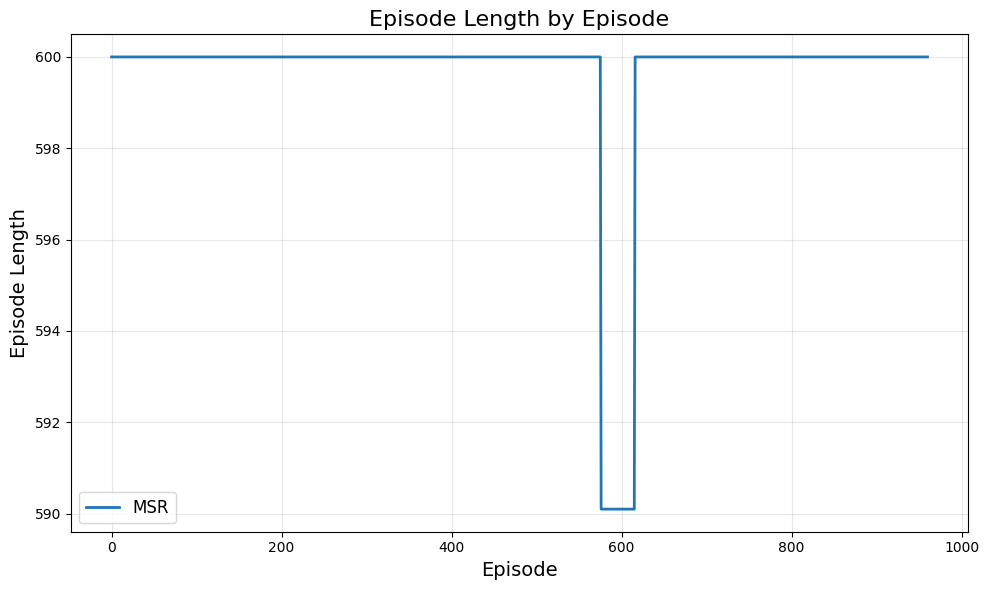

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

#ax.plot(length_dqn, linewidth=2, label="DQN")
ax.plot(length_rolling_msr,  linewidth=2, label="MSR")
#ax.plot(length_rolling_srdec,  linewidth=2, label="SR - Decomposed R")
#ax.plot(length_ql,  linewidth=2, label="QL")
#ax.plot(length_dsr,  linewidth=2, label="DSR")

ax.set_title("Episode Length by Episode", fontsize=16)
ax.set_xlabel("Episode", fontsize=14)
ax.set_ylabel("Episode Length", fontsize=14)

ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

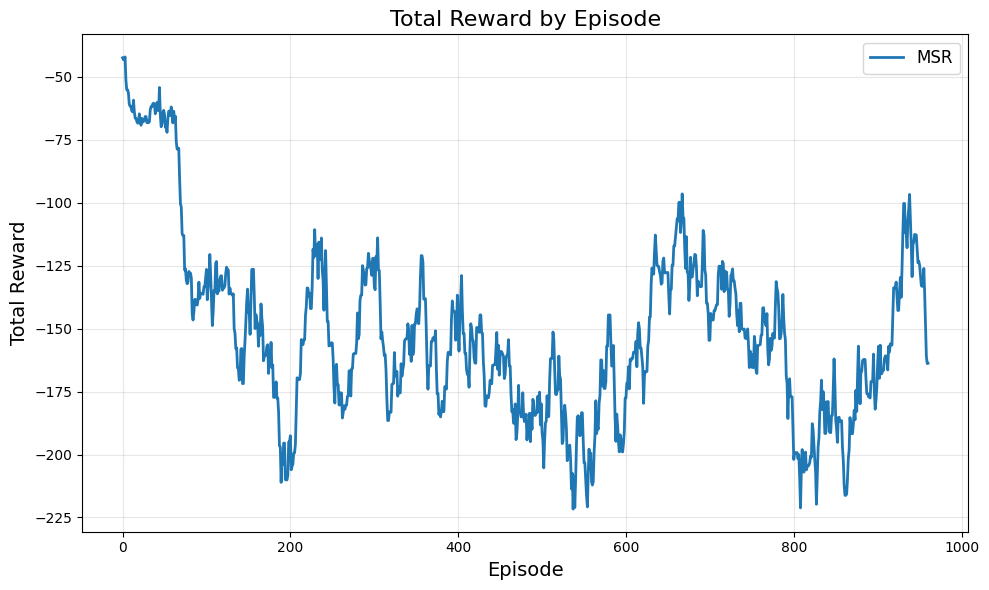

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

#ax.plot(rewards_dqn, linewidth=2, label="DQN")
ax.plot(rewards_rolling_msr,  linewidth=2, label="MSR")
#ax.plot(rewards_rolling_srdec,  linewidth=2, label="SR - Decomposed R")
#ax.plot(rewards_ql,  linewidth=2, label="QL")
#ax.plot(rewards_dsr,  linewidth=2, label="DSR")

ax.set_title("Total Reward by Episode", fontsize=16)
ax.set_xlabel("Episode", fontsize=14)
ax.set_ylabel("Total Reward", fontsize=14)

ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()